You can order print and ebook versions of *Think Bayes 2e* from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

# Operations with Distributions

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [7]:
import sys
import empiricaldist
from os.path import basename, exists
from utils import set_pyplot_params
set_pyplot_params()

This chapter is about distributions of sums and results of other operations.
We'll start with a forward problem, where we are given the inputs and compute the distribution of the output.
Then we'll work on inverse problems, where we are given the outputs and we compute the distribution of the inputs.

As a first example, suppose you roll two dice and add them up. What is the distribution of the sum? 
I’ll use the following function to create a `Pmf` that represents the
possible outcomes of a die:

In [8]:
import numpy as np
from empiricaldist import Pmf

def make_die(sides):
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

On a six-sided die, the outcomes are 1 through 6, all
equally likely.

In [9]:
die = make_die(6)

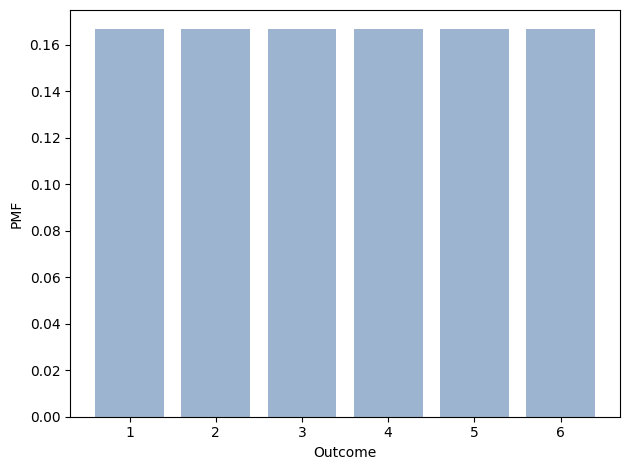

In [10]:
from utils import decorate

die.bar(alpha=0.4)
decorate(xlabel='Outcome',
         ylabel='PMF')

If we roll two dice and add them up, there are 11 possible outcomes, 2
through 12, but they are not equally likely. To compute the distribution
of the sum, we have to enumerate the possible outcomes. 

In [11]:
# convolution of two vectors
# must watch https://www.youtube.com/watch?v=KuXjwB4LzSA&t=642s

np.convolve(die,die)

array([0.02777778, 0.05555556, 0.08333333, 0.11111111, 0.13888889,
       0.16666667, 0.13888889, 0.11111111, 0.08333333, 0.05555556,
       0.02777778])

The actual equation for the convolution is:

\begin{equation*} 
(a * b)_n=\sum_{\substack{i, j \\ i+j=n}} a_i \cdot b_j = \sum_{i}^{6} a_i \cdot b_{n-i}
\end{equation*}

And that's how this function works:

In [12]:
def add_dist(pmf1, pmf2):
    """Compute the distribution of a sum."""
    res = Pmf()
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            q = q1 + q2
            p = p1 * p2
            res[q] = res(q) + p
    return res

The parameters are `Pmf` objects representing distributions.

The loops iterate though the quantities and probabilities in the `Pmf` objects.
Each time through the loop `q` gets the sum of a pair of quantities, and `p` gets the probability of the pair.
Because the same sum might appear more than once, we have to add up the total probability for each sum.

Notice a subtle element of this line:

```
            res[q] = res(q) + p
```

I use parentheses on the right side of the assignment, which returns 0 if `q` does not appear yet in `res`.
I use brackets on the left side of the assignment to create or update an element in `res`; using parentheses on the left side would not work.

`Pmf` provides `add_dist`, which does the same thing.
You can call it as a method, like this:

In [13]:
twice = die.add_dist(die)

Or as a function, like this:

In [14]:
twice = Pmf.add_dist(die, die)

And here's what the result looks like:

In [15]:
from utils import decorate

def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

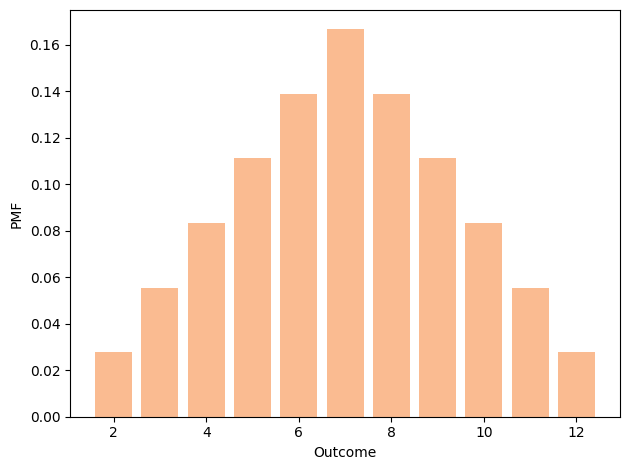

In [16]:
twice = add_dist(die, die)
twice.bar(color='C1', alpha=0.5)
decorate_dice()

If we have a sequence of `Pmf` objects that represent dice, we can compute the distribution of the sum like this:


In [29]:
def add_dist_seq(seq):
    """Compute Pmf of the sum of values from seq."""
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

As an example, we can make a list of three dice like this:

In [30]:
dice = [die] * 3

And we can compute the distribution of their sum like this.

In [31]:
thrice = add_dist_seq(dice)

The following figure shows what these three distributions look like:

-   The distribution of a single die is uniform from 1 to 6.

-   The sum of two dice has a triangle distribution between 2 and 12.

-   The sum of three dice has a bell-shaped distribution between 3
    and 18.

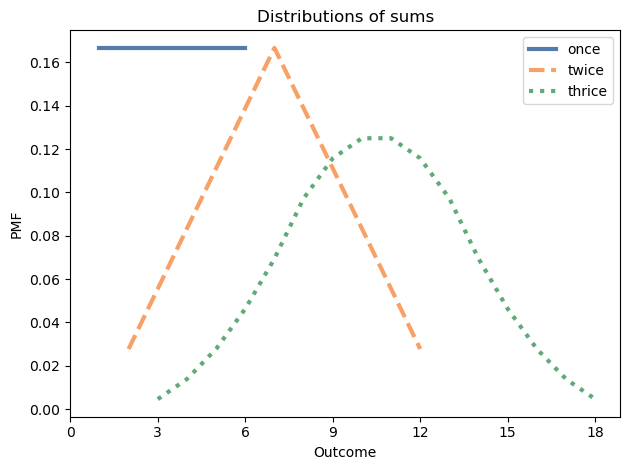

In [32]:
import matplotlib.pyplot as plt

die.plot(label='once')
twice.plot(label='twice', ls='--')
thrice.plot(label='thrice', ls=':')

plt.xticks([0,3,6,9,12,15,18])
decorate_dice(title='Distributions of sums')

As an aside, this example demonstrates the *Central Limit Theorem*, which says that the distribution of a sum converges on a bell-shaped normal distribution, at least under some conditions.

## Gluten Sensitivity

In 2015 I read a paper that tested whether people diagnosed with gluten sensitivity (but not celiac disease) were able to distinguish gluten flour from non-gluten flour in a blind challenge
([you can read the paper here](https://onlinelibrary.wiley.com/doi/full/10.1111/apt.13372)).

Out of 35 subjects, 12 correctly identified the gluten flour based on
resumption of symptoms while they were eating it. Another 17 wrongly
identified the gluten-free flour based on their symptoms, and 6 were
unable to distinguish.

The authors conclude, "Double-blind gluten challenge induces symptom
recurrence in just one-third of patients."

This conclusion seems odd to me, because if none of the patients were
sensitive to gluten, we would expect some of them to identify the gluten flour by chance. 
So here's the question: based on this data, how many of the subjects are sensitive to gluten and how many are guessing?

We can use Bayes's Theorem to answer this question, but first we have to make some modeling decisions. I'll assume:

-   People who are sensitive to gluten have a 95% chance of correctly
    identifying gluten flour under the challenge conditions, and

-   People who are not sensitive have a 40% chance of identifying the
    gluten flour by chance (and a 60% chance of either choosing the
    other flour or failing to distinguish).

These particular values are arbitrary, but the results are not sensitive to these choices.

I will solve this problem in two steps. First, assuming that we know how many subjects are sensitive, I will compute the distribution of the data. 
Then, using the likelihood of the data, I will compute the posterior distribution of the number of sensitive patients.

The first is the **forward problem**; the second is the **inverse
problem**.

## The Forward Problem

Suppose we know that 10 of the 35 subjects are sensitive to gluten. That
means that 25 are not:

In [ ]:
n = 35
num_sensitive = 10 #pq ha puesto 10 y no 12?
num_insensitive = n - num_sensitive

Each sensitive subject has a 95% chance of identifying the gluten flour,
so the number of correct identifications follows a binomial distribution.

I'll use `make_binomial`, which we defined in <<_TheBinomialDistribution>>, to make a `Pmf` that represents the binomial distribution.

In [28]:
from utils import make_binomial

dist_sensitive = make_binomial(num_sensitive, 0.95)
dist_insensitive = make_binomial(num_insensitive, 0.40)

The results are the distributions for the number of correct identifications in each group.

Now we can use `add_dist` to compute the distribution of the total number of correct identifications:

In [29]:
dist_sensitive

,probs
0,2.441406e-16
1,5.566406e-14
2,5.816895e-12
3,3.684033e-10
4,1.574924e-08
5,4.787770e-07
6,1.061289e-05
7,1.728385e-04
8,2.052457e-03
9,1.733186e-02


In [30]:
dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)

Here are the results:

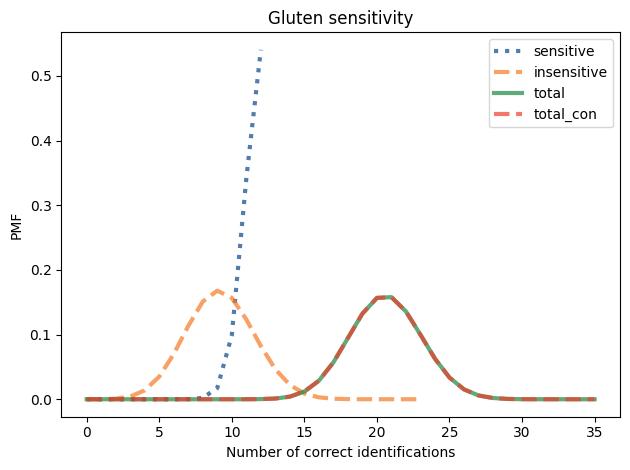

In [31]:
import matplotlib.pyplot as plt
dist_sensitive.plot(label='sensitive', ls=':')
dist_insensitive.plot(label='insensitive', ls='--')
dist_total.plot(label='total')
aa = np.convolve(dist_sensitive,dist_insensitive)
plt.plot(aa,'--',label='total_con')

decorate(xlabel='Number of correct identifications',
         ylabel='PMF',
         title='Gluten sensitivity')

We expect most of the sensitive subjects to identify the gluten flour correctly.
Of the 25 insensitive subjects, we expect about 10 to identify the gluten flour by chance.
So we expect about 20 correct identifications in total.

This is the answer to the forward problem: given the number of sensitive subjects, we can compute the distribution of the data.

## The Inverse Problem

Now let's solve the inverse problem: given the data, we'll compute the posterior distribution of the number of sensitive subjects.

Here's how.  I'll loop through the possible values of `num_sensitive` and compute the distribution of the data for each:

In [32]:
import pandas as pd

table = pd.DataFrame()
for num_sensitive in range(0, n+1):
    num_insensitive = n - num_sensitive
    dist_sensitive = make_binomial(num_sensitive, 0.95)
    dist_insensitive = make_binomial(num_insensitive, 0.4)
    dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)    
    table[num_sensitive] = dist_total

The loop enumerates the possible values of `num_sensitive`.
For each value, it computes the distribution of the total number of correct identifications, and stores the result as a column in a Pandas `DataFrame`.

In [33]:
table.head(3)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.719071e-08,1.432559e-09,1.193799e-10,9.948326e-12,8.290272e-13,6.908560e-14,5.757133e-15,4.797611e-16,3.998009e-17,3.331674e-18,...,1.501694e-36,1.251411e-37,1.042843e-38,8.690357e-40,7.241964e-41,6.034970e-42,5.029142e-43,4.190952e-44,3.492460e-45,2.910383e-46
1,4.011165e-07,5.968996e-08,7.162795e-09,7.792856e-10,8.013930e-11,7.944844e-12,7.676178e-13,7.276377e-14,6.796616e-15,6.274653e-16,...,7.508469e-34,6.486483e-35,5.596590e-36,4.823148e-37,4.152060e-38,3.570691e-39,3.067777e-40,2.633315e-41,2.258457e-42,1.935405e-43
2,4.545987e-06,9.741401e-07,1.709122e-07,2.506426e-08,3.269131e-09,3.940182e-10,4.490244e-11,4.908756e-12,5.197412e-13,5.365476e-14,...,1.806613e-31,1.620070e-32,1.449030e-33,1.292922e-34,1.151034e-35,1.022555e-36,9.066202e-38,8.023344e-39,7.088005e-40,6.251357e-41


The following figure shows selected columns from the `DataFrame`, corresponding to different hypothetical values of `num_sensitive`:

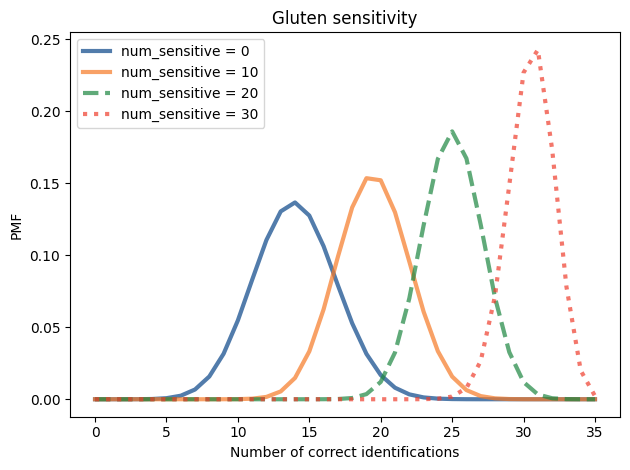

In [34]:
table[0].plot(label='num_sensitive = 0')
table[10].plot(label='num_sensitive = 10')
table[20].plot(label='num_sensitive = 20', ls='--')
table[30].plot(label='num_sensitive = 30', ls=':')
    
decorate(xlabel='Number of correct identifications',
         ylabel='PMF',
         title='Gluten sensitivity')

Now we can use this table to compute the likelihood of the data:

In [35]:
likelihood1 = table.loc[12]

`loc` selects a row from the `DataFrame`.
The row with index 12 contains the probability of 12 correct identifications for each hypothetical value of `num_sensitive`.
And that's exactly the likelihood we need to do a Bayesian update.

I'll use a uniform prior, which implies that I would be equally surprised by any value of `num_sensitive`:

In [36]:
hypos = np.arange(n+1)
prior = Pmf(1, hypos)

And here's the update:


In [37]:
posterior1 = prior * likelihood1
posterior1.normalize()

0.47547416486151295

For comparison, I also compute the posterior for another possible outcome, 20 correct identifications.

In [38]:
likelihood2 = table.loc[20]
posterior2 = prior * likelihood2
posterior2.normalize()

1.781864976588738

The following figure shows posterior distributions of `num_sensitive` based on the actual data, 12 correct identifications, and the other possible outcome, 20 correct identifications.

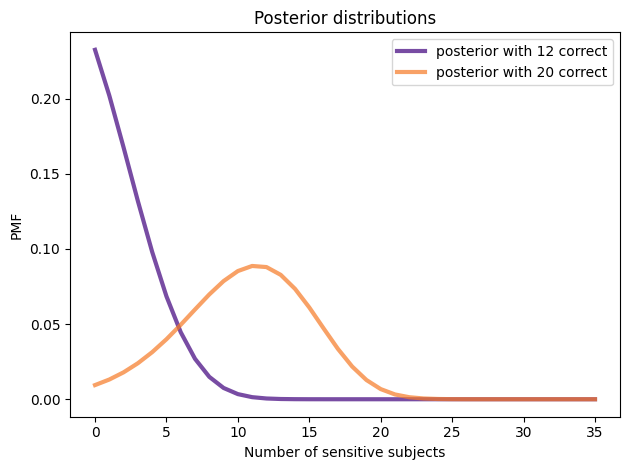

In [39]:
posterior1.plot(label='posterior with 12 correct', color='C4')
posterior2.plot(label='posterior with 20 correct', color='C1')

decorate(xlabel='Number of sensitive subjects',
         ylabel='PMF',
         title='Posterior distributions')

With 12 correct identifications, the most likely conclusion is that none of the subjects are sensitive to gluten.
If there had been 20 correct identifications, the most likely conclusion would be that 11-12 of the subjects were sensitive.

In [40]:
posterior1.max_prob()

0

In [41]:
posterior2.max_prob()

11

## Summary

This chapter presents two topics that are almost unrelated except that they make the title of the chapter catchy.

The first part of the chapter is about Bayes's Rule, evidence, and how we can quantify the strength of evidence using a likelihood ratio or Bayes factor.

The second part is about `add_dist`, which computes the distribution of a sum.
We can use this function to solve forward and inverse problems; that is, given the parameters of a system, we can compute the distribution of the data or, given the data, we can compute the distribution of the parameters.

In the next chapter, we'll compute distributions for minimums and maximums, and use them to solve more Bayesian problems.
But first you might want to work on these exercises.

## Exercises

**Exercise:** Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
I choose one of the dice at random, roll it twice, multiply the outcomes, and report that the product is 12.
What is the probability that I chose the 8-sided die?

Hint: `Pmf` provides a function called `mul_dist` that takes two `Pmf` objects and returns a `Pmf` that represents the distribution of the product.

$$(a *' b)_n=\sum_{\substack{i, j \\ i \cdot j=n}} a_i \cdot b_j$$

In [48]:
hypos = [6,8,12]
prior = Pmf(1,hypos)

likelihood = []

for sides in hypos:
    die = make_die(sides)
    pmf = Pmf.mul_dist(die,die)
    likelihood.append(pmf[12])
likelihood

[0.1111111111111111, 0.0625, 0.041666666666666664]

In [49]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
6,0.516129
8,0.290323
12,0.193548


**Exercise:** There are 538 members of the United States Congress. Suppose we audit their investment portfolios and find that 312 of them out-perform the market.
Let's assume that an honest member of Congress has only a 50% chance of out-performing the market, but a dishonest member who trades on inside information has a 90% chance.  How many members of Congress are honest?

In [43]:
# Solution